# Demo of UNet Stable Diffusion

In [1]:
# This implementation is based on this colab notebook:
# https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing

In [2]:
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from torchvision import transforms 
from PIL import Image
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

# Loading the Dataset

In [3]:
# IMPORTANT: Make sure to download the dataset in install.ipynb
# https://github.com/cyizhuo/Stanford-Cars-dataset

class CustomStanfordCarsDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.car_names = sorted(os.listdir(img_dir))  # Assuming car names are the class labels
        
        for idx, car_name in enumerate(self.car_names):
            car_dir = os.path.join(img_dir, car_name)
            for img_name in os.listdir(car_dir):
                self.image_paths.append(os.path.join(car_dir, img_name))
                self.labels.append(idx)  # Use the index of the car name as the label

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Viewing the Dataset

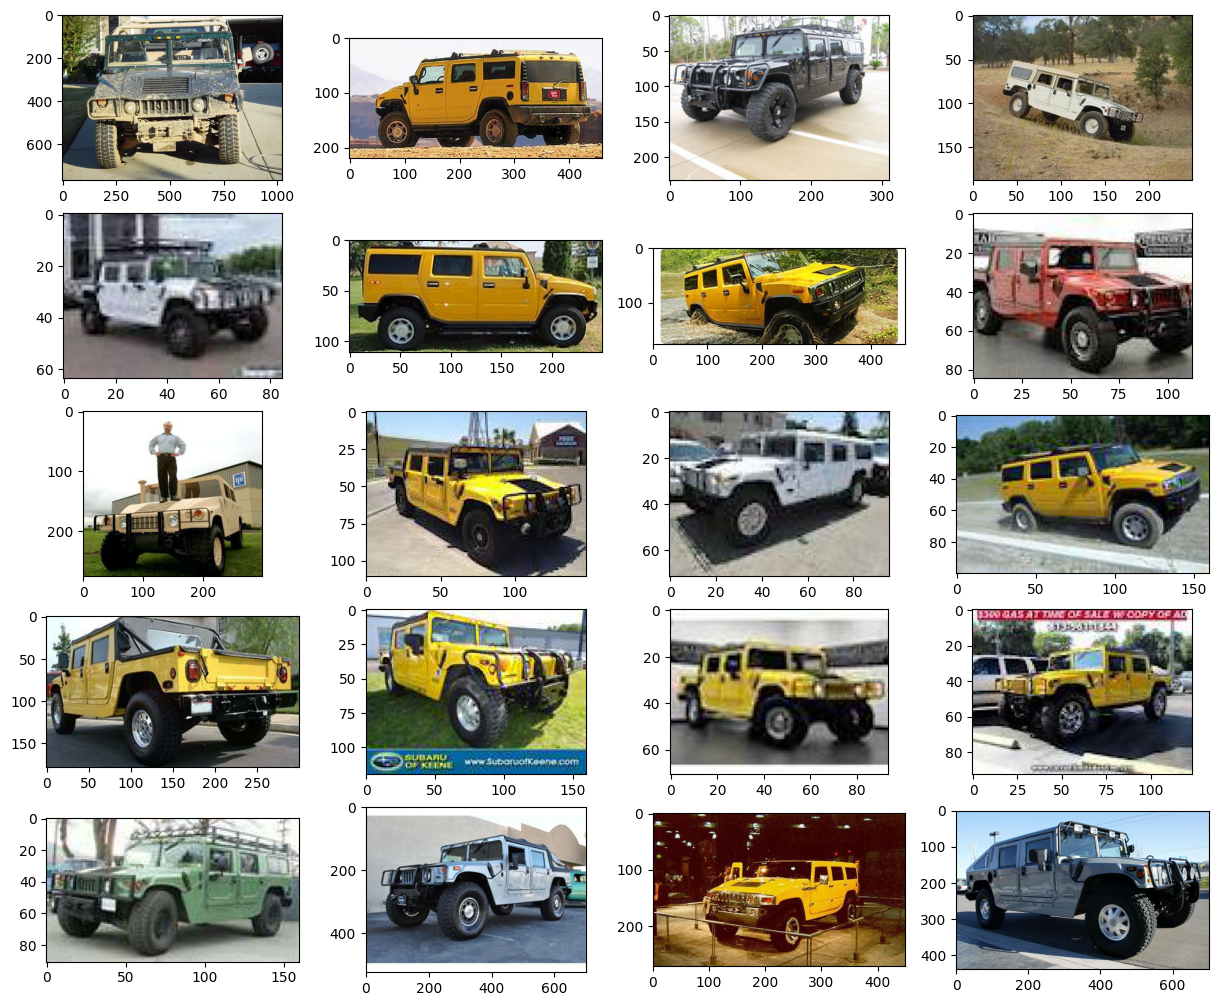

In [4]:
def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

data = CustomStanfordCarsDataset('Stanford-Cars-dataset/train')
show_images(data)

# Defining the noise scheduler

In [5]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [6]:
IMG_SIZE = 64
BATCH_SIZE = 32

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)

    train = CustomStanfordCarsDataset('Stanford-Cars-dataset/train', transform=data_transform)

    test = CustomStanfordCarsDataset('Stanford-Cars-dataset/test', transform=data_transform)
    
    return torch.utils.data.ConcatDataset([train, test])
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

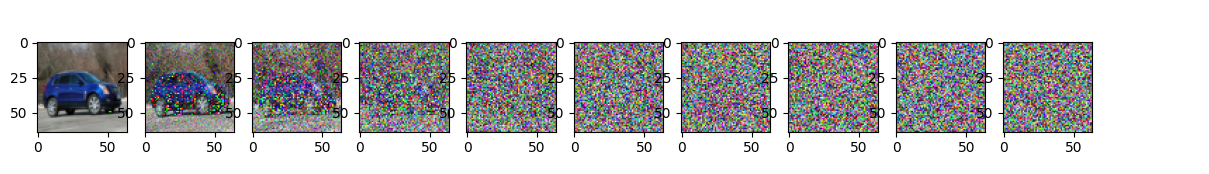

In [7]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,2))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

# Initializing the model

In [8]:
from unet import SimpleUnet

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  22815115
Num params:  22815115


# Initializing the training

In [9]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [10]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,2))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()            

# Training the model

In [ ]:
from torch.optim import Adam
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 400 
s = time.time()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      
      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()
        
      if step % 50 == 0:
        sample_plot_image()
        #print(time.time() - s)
        s = time.time()

    
      print(f"\r Epoch: {epoch} | Train Loss {loss.item()}", end="")

# FID Score

In [12]:
from tqdm import tqdm
from fid import fid_score

In [13]:
def gen(n):
    img_size = IMG_SIZE
    img = torch.randn((n, 3, img_size, img_size), device=device)
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        img = torch.clamp(img, -1.0, 1.0)
    return img

def calculate_FID(dataset, model, n_samples=100):
    real_list, fake_list = [dataset[i][0] for i in range(n_samples)], []
    for i in tqdm(range(int(len(real_list)//100))):
        f = gen(100)
        for z in f:
            fake_list.append(z)
    fake_list = torch.stack(fake_list)

    fid = fid_score(fake_list, torch.stack(real_list), device='cuda')
    return fid

In [ ]:
UNetFID = 0
with torch.no_grad():
    UNetFID = calculate_FID(data, model, n_samples=16000)
print("FID score for UNet model: ", UNetFID)